In [3]:
!pip install numpy pandas seaborn matplotlib

Ignoring numpy: markers 'python_version < "3.11"' don't match your environment


All required libraries are installed.
pandas version: 2.3.1
Dataset loaded successfully:
                              MTU (CET/CEST)    Area          Sequence  \
0  01/01/2024 00:00:00 - 01/01/2024 01:00:00  BZN|CZ  Without Sequence   
1  01/01/2024 01:00:00 - 01/01/2024 02:00:00  BZN|CZ  Without Sequence   
2  01/01/2024 02:00:00 - 01/01/2024 03:00:00  BZN|CZ  Without Sequence   
3  01/01/2024 03:00:00 - 01/01/2024 04:00:00  BZN|CZ  Without Sequence   
4  01/01/2024 04:00:00 - 01/01/2024 05:00:00  BZN|CZ  Without Sequence   

   Day-ahead Price (EUR/MWh)  Intraday Period (CET/CEST)  \
0                       0.10                         NaN   
1                       0.01                         NaN   
2                       0.02                         NaN   
3                       0.00                         NaN   
4                      -0.01                         NaN   

   Intraday Price (EUR/MWh)  
0                       NaN  
1                       NaN  
2              

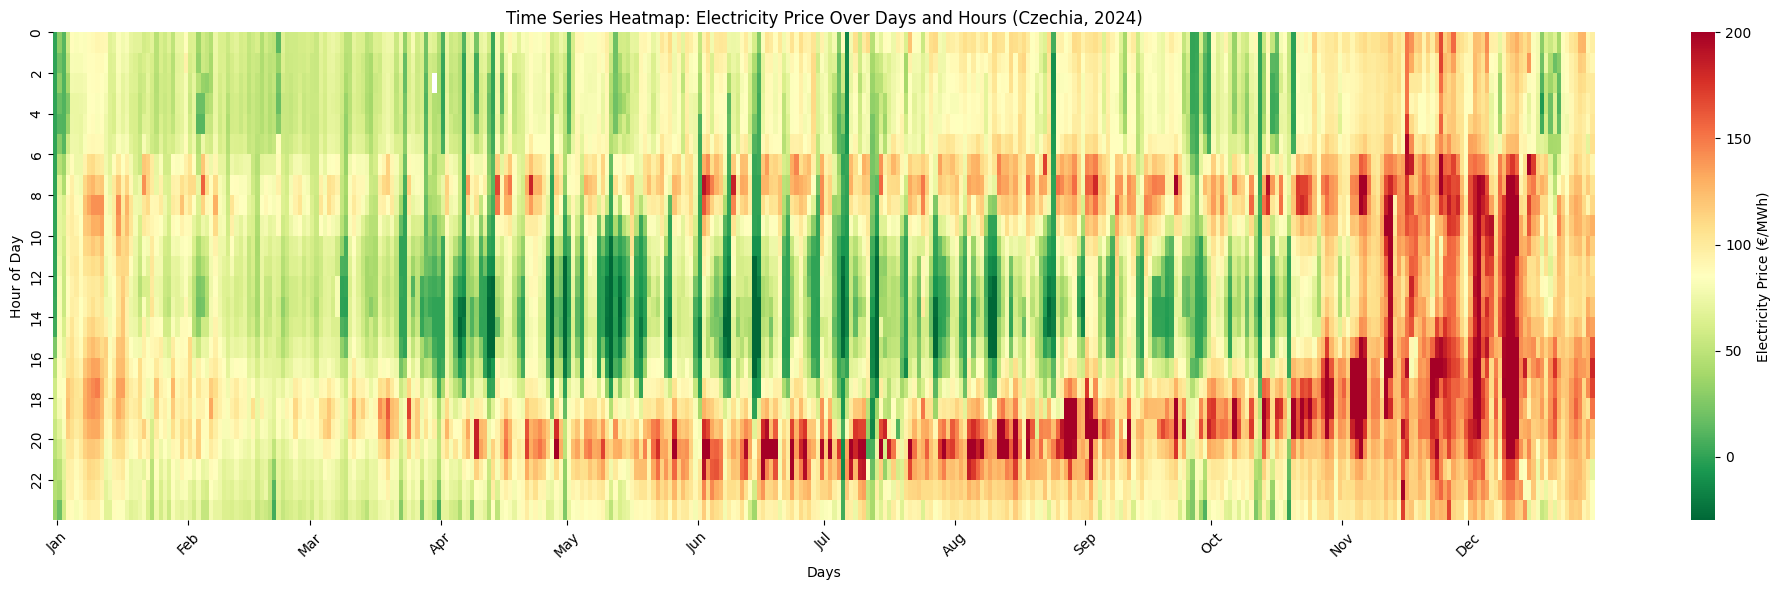

In [15]:
# Import required libraries
import os
from datetime import datetime
import numpy as np
try:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    print("All required libraries are installed.")
    print(f"pandas version: {pd.__version__}")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install required libraries: pip install pandas seaborn matplotlib")
    raise

# Define the URL to the CSV file
file_url = "https://raw.githubusercontent.com/jsitera/GreenComputing/refs/heads/main/data/ENTSO-E/electricity-prices-2024.csv"

# Load the CSV file
try:
    df = pd.read_csv(file_url)
    print("Dataset loaded successfully:")
    print(df.head())
except Exception as e:
    print(f"Error loading file: {str(e)}")
    raise

# Define columns
datetime_col = 'MTU (CET/CEST)'  # Time interval column (DD/MM/YYYY HH:MM:SS)
price_col = 'Day-ahead Price (EUR/MWh)'  # Day-ahead price in €/MWh

# Check if expected columns exist
missing_cols = [col for col in [datetime_col, area_col, price_col] if col not in df.columns]
if missing_cols:
    print(f"Error: Missing columns {missing_cols}. Available columns: {df.columns.tolist()}")
    raise ValueError("Missing required columns")

# Convert datetime column to pandas datetime
# MTU (CET/CEST) format: e.g., '01/01/2024 00:00:00 - 01/01/2024 01:00:00'
# Extract start time and parse with DD/MM/YYYY HH:MM:SS format
try:
    # Remove anything like '(CET)' before parsing
    df[datetime_col] = df[datetime_col].str.split('-').str[0].str.replace(r'\s*\(.*\)', '', regex=True).str.strip()
    df[datetime_col] = pd.to_datetime(df[datetime_col], format='%d/%m/%Y %H:%M:%S', errors='coerce')
except Exception as e:
    print(f"Error converting '{datetime_col}' to datetime: {str(e)}")
    print("Inspect datetime format:")
    print(df[datetime_col].head())
    print("Expected format: 'DD/MM/YYYY HH:MM:SS', e.g., '01/01/2024 00:00:00'")
    raise

# Print price statistics to confirm scale
print("Day-ahead Price statistics (€/MWh):")
print(df[price_col].describe())

# Extract day of year and hour for pivot table
df['day_of_year'] = df[datetime_col].dt.dayofyear
df['hour'] = df[datetime_col].dt.hour

# Create a pivot table for the heatmap (hours vs. days)
pivot_table = df.pivot_table(index='hour', columns='day_of_year', values=price_col, aggfunc='mean')

# Plot the heatmap with fixed price scale
plt.figure(figsize=(20, 6))  # Match snippet figure size
sns.heatmap(pivot_table, cmap='RdYlGn_r', cbar_kws={'label': 'Electricity Price (€/MWh)'}, vmin=-30, vmax=200)
plt.title(f"Time Series Heatmap: Electricity Price Over Days and Hours (Czechia, 2024)")
plt.xlabel("Days")
plt.ylabel("Hour of Day")

# Customize x-axis with month start dates
year = 2024
month_starts = [datetime(year, m, 1) for m in range(1, 13)]  # Jan 1, Feb 1, ..., Dec 1
start_date = pd.Timestamp(f"{year}-01-01")  # Start of the year
days_since_start = [(d - start_date).days + 1 for d in month_starts]  # Convert to day-of-year indices
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(days_since_start, month_labels, rotation=45)

# Customize y-axis to show every 2 hours
plt.yticks(np.arange(0, 24, 2), range(0, 24, 2))

plt.tight_layout()

# Save the plot to a file
output_file = f"heatmap_electricity_price_CZ_2024.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Heatmap saved to {output_file}")

# Show the plot
plt.show()